In [1]:
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
ab_data = pd.read_csv('ab_data.csv')

In [3]:
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [4]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290482 entries, 0 to 290481
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290482 non-null  int64 
 1   timestamp  290482 non-null  object
 2   group      290482 non-null  object
 3   converted  290482 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 8.9+ MB


In [5]:
ab_data['timestamp'] = pd.to_datetime(ab_data['timestamp'], format='%Y-%m-%d')

In [7]:
daily_data = ab_data.groupby(['timestamp', 'group']).agg({
    'user_id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user_id':'users_count'})
daily_data.head()

,timestamp,group,users_count,converted
0,2017-01-02,A,2851,357
1,2017-01-02,B,2848,339
2,2017-01-03,A,6584,749
3,2017-01-03,B,6620,754
4,2017-01-04,A,6573,797


In [9]:

daily_data['conversion'] = (daily_data['converted']/daily_data['users_count'])
round(daily_data[(daily_data['timestamp'] == '2017-01-05') & (daily_data['group'] == 'A')]['conversion'],2)

6    0.12
Name: conversion, dtype: float64

In [10]:
daily_data.head()

,timestamp,group,users_count,converted,conversion
0,2017-01-02,A,2851,357,0.125219
1,2017-01-02,B,2848,339,0.119031
2,2017-01-03,A,6584,749,0.113761
3,2017-01-03,B,6620,754,0.113897
4,2017-01-04,A,6573,797,0.121254


### ВИЗУАЛЬНЫЙ АНАЛИЗ КОНВЕРСИИ В ГРУППАХ

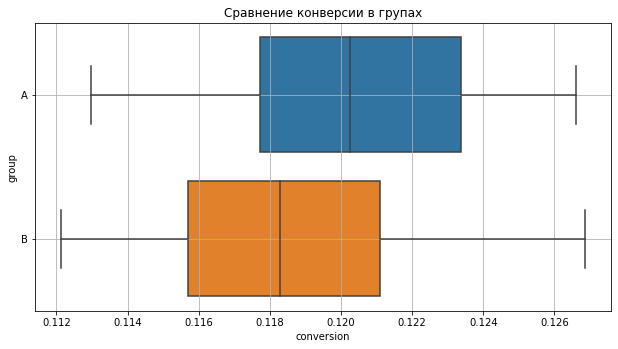

In [11]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])
sns.boxplot(data=daily_data, x='conversion', y='group', ax=ax)
ax.set_title('Сравнение конверсии в групах')
ax.grid();

In [12]:
conversion_piv = daily_data.groupby('group')['conversion'].agg(
    ['mean', 'median']
)
conversion_piv

,mean,median
group,,
A,0.120329,0.120243
B,0.118727,0.118296


### показатели ежедневной конверсии в каждой группе во времени

<bound method _AxesBase.grid of <matplotlib.axes._axes.Axes object at 0x7f9362e96b50>>

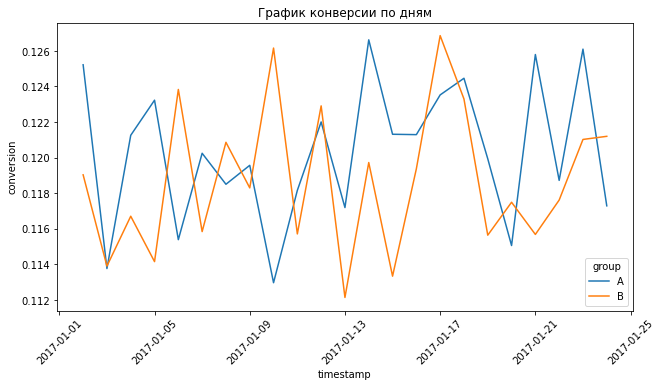

In [13]:
fig = plt.figure(figsize=(8,4))

ax = fig.add_axes([1,1,1,1])

sns.lineplot(
    data=daily_data,
    x='timestamp',
    y='conversion',
    hue='group',
    ax=ax
)
ax.set_title('График конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid

In [16]:
daily_data_a = daily_data[daily_data['group'] == 'A']
daily_data_a.loc[:, 'cum_users_count'] = daily_data_a['users_count'].cumsum()
daily_data_a[['timestamp', 'users_count', 'cum_users_count']].head()


,timestamp,users_count,cum_users_count
0,2017-01-02,2851,2851
2,2017-01-03,6584,9435
4,2017-01-04,6573,16008
6,2017-01-05,6419,22427
8,2017-01-06,6604,29031


In [17]:
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
daily_data['cum_converted'] = daily_data.groupby(['group'])['converted'].cumsum()
daily_data['cum_conversion'] = daily_data['cum_converted']/daily_data['cum_users_count'] * 100
daily_data.head()

,timestamp,group,users_count,converted,conversion,cum_users_count,cum_converted,cum_conversion
0,2017-01-02,A,2851,357,0.125219,2851,357,12.521922
1,2017-01-02,B,2848,339,0.119031,2848,339,11.903090
2,2017-01-03,A,6584,749,0.113761,9435,1106,11.722311
3,2017-01-03,B,6620,754,0.113897,9468,1093,11.544149
4,2017-01-04,A,6573,797,0.121254,16008,1903,11.887806


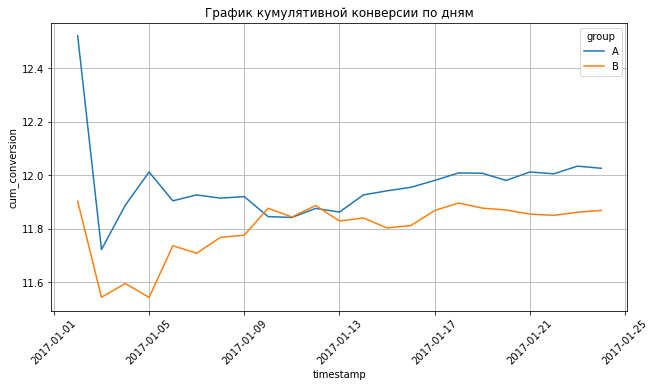

In [18]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])
sns.lineplot(x='timestamp', y = 'cum_conversion', data=daily_data, hue='group', ax=ax)
ax.set_title('График кумулятивной конверсии по дням')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

In [19]:
sample_a = pd.read_csv('ab_test-redesign_sample_a.csv')
sample_b = pd.read_csv('ab_test-redesign_sample_b.csv')

In [20]:
sample_a

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A
3,2020-11-06,1.004393e+09,0,0,A
4,2020-11-06,1.006382e+09,0,0,A
...,...,...,...,...,...
61566,2020-11-23,9.986289e+08,0,0,A
61567,2020-11-23,9.989196e+08,0,0,A
61568,2020-11-23,9.990631e+08,0,0,A
61569,2020-11-23,9.994210e+07,0,0,A


In [23]:
sample_a['date'] = pd.to_datetime(sample_a['date'], format='%Y-%m-%d')

gr_sample_a  = sample_a.groupby(['date']).agg({
    'cid': 'count',
    'transactions': 'sum', 
    'revenue': 'sum'
}).reset_index().rename(columns={'cid':'count_users', 'transactions': 'count_transaction', 'revenue': 'sum_revenue'})
gr_sample_a

sample_b['date'] = pd.to_datetime(sample_b['date'], format='%Y-%m-%d')

gr_sample_b  = sample_b.groupby(['date']).agg({
    'cid': 'count',
    'transactions': 'sum', 
    'revenue': 'sum'
}).reset_index().rename(columns={'cid':'count_users', 'transactions': 'count_transaction', 'revenue': 'sum_revenue'})
gr_sample_b


,date,count_users,count_transaction,sum_revenue
0,2020-11-06,2499,19,996645
1,2020-11-07,2804,19,555499
2,2020-11-08,3291,24,3044842
3,2020-11-09,3062,25,1285836
4,2020-11-10,3072,30,2414726
5,2020-11-11,3208,22,3555727
6,2020-11-12,3494,25,915653
7,2020-11-13,3606,37,1703475
8,2020-11-14,3276,34,2369998
9,2020-11-15,3919,27,1147144


In [24]:
gr_sample_a['cum_users'] = gr_sample_a['count_users'].cumsum()
gr_sample_a['cum_transactions'] = gr_sample_a['count_transaction'].cumsum()
gr_sample_a['cum_revenue'] = gr_sample_a['sum_revenue'].cumsum()
gr_sample_a['cum_conversion'] = gr_sample_a['cum_transactions']/gr_sample_a['cum_users'] * 100
gr_sample_a['cum_avg_cheque'] = gr_sample_a['cum_revenue']/gr_sample_a['cum_transactions'] * 100


gr_sample_b['cum_users'] = gr_sample_b['count_users'].cumsum()
gr_sample_b['cum_transactions'] = gr_sample_b['count_transaction'].cumsum()
gr_sample_b['cum_revenue'] = gr_sample_b['sum_revenue'].cumsum()
gr_sample_b['cum_conversion'] = gr_sample_b['cum_transactions']/gr_sample_b['cum_users'] * 100
gr_sample_b['cum_avg_cheque'] = gr_sample_b['cum_revenue']/gr_sample_b['cum_transactions'] * 100

In [25]:
round(gr_sample_a['cum_conversion'].mean(),2)
round(gr_sample_b['cum_conversion'].mean(),2)

0.76

### графики кумулятивной конверсии в каждой группе

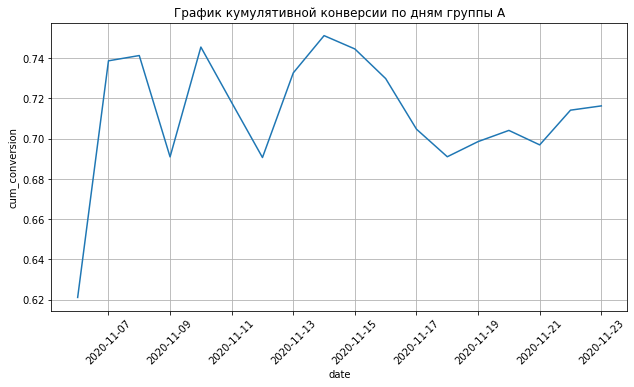

In [29]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])

sns.lineplot(x='date', y = 'cum_conversion', data=gr_sample_a, ax=ax)
ax.set_title('График кумулятивной конверсии по дням группы A')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

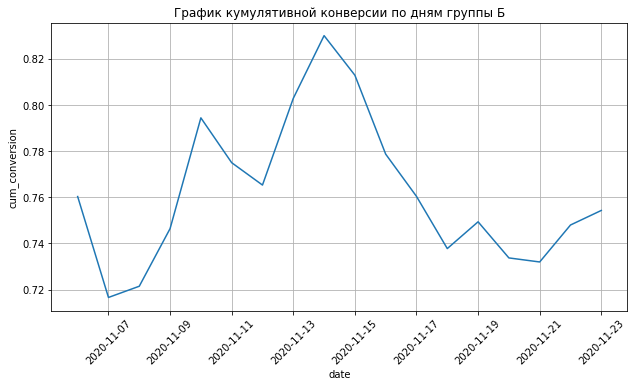

In [27]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])

sns.lineplot(x='date', y = 'cum_conversion', data=gr_sample_b, ax=ax)
ax.set_title('График кумулятивной конверсии по дням группы Б')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

In [ ]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])

sns.lineplot(x='date', y = 'cum_revenue', data=gr_sample_a, ax=ax)
ax.set_title('График кумулятивной среднего чека по дням группы A')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

In [ ]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_axes([1,1,1,1])

sns.lineplot(x='date', y = 'cum_revenue', data=gr_sample_b, ax=ax)
ax.set_title('График кумулятивной среднего чека по дням группы Б')
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True)

### СТАТИСТИЧЕСКИЙ ТЕСТ ДЛЯ КОНВЕРСИИ

In [30]:
ab_data

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1
...,...,...,...,...
290477,751197,2017-01-03,A,0
290478,945152,2017-01-12,A,0
290479,734608,2017-01-22,A,0
290480,697314,2017-01-15,A,0


In [31]:
converted_piv = ab_data.groupby('group')['converted'].agg(
    ['sum', 'count']
)
converted_piv

,sum,count
group,,
A,17467,145241
B,17238,145241


In [33]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.1
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


### Проверьте гипотезу о равенстве конверсий в группах А и B 

In [34]:
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А меньше, чем конверсия в группе B'
alpha = 0.1

conv_piv_a = sample_a.groupby('group')['transactions'].agg(
    ['sum', 'count']
)
conv_piv_a
conv_piv_b = sample_b.groupby('group')['transactions'].agg(
    ['sum', 'count']
)
conv_piv_b
conv_piv = pd.concat([conv_piv_a, conv_piv_b], ignore_index=False)


_, p_value = proportions_ztest(
    count=conv_piv['sum'], #число "успехов"
    nobs=conv_piv['count'], #общее число наблюдений
    alternative='smaller',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 

p-value:  0.22
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Проверьте гипотезу о нормальности распределений ежедневного среднего чека с помощью критерия Шапиро-Уилка

In [36]:
everyday_cheque_a = sample_a.groupby('date').agg({
    'revenue': 'mean'
}).reset_index().rename(columns={'revenue': 'avg_cheque_a'})
everyday_cheque_b = sample_b.groupby('date').agg({
    'revenue': 'mean'
}).reset_index().rename(columns={'revenue': 'avg_cheque_b'})


# нулевая и альтернативная гипотезы
H0 = 'Распределения ежденевного среднего чека в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.1 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок

shapiro_result_a = shapiro(everyday_cheque_a['avg_cheque_a'])
shapiro_result_b = shapiro(everyday_cheque_b['avg_cheque_b'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.01
p-value группы B 0.15
Отвергаем нулевую гипотезу. Распределения ежденевного среднего чека в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


Проверьте гипотезу о равенстве ежедневных средних чеков с помощью критерия Манна-Уитни

In [37]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения ежденевного среднего чека в обеих группах нормальные'
H1 = 'Распределение среднего чека в группе А меньше чем в группе B'
alpha = 0.1 # уровень значимости

U1, p_value = mannwhitneyu(everyday_cheque_a['avg_cheque_a'], everyday_cheque_b['avg_cheque_b'], alternative="less")
# выводим результат на экран
print('p-value: ', round(p_value, 2))
if p_value < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))




p-value:  0.07
Отвергаем нулевую гипотезу. Распределения ежденевного среднего чека в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение среднего чека в группе А меньше чем в группе B


In [38]:
n = 36 # размер выборки
x_mean = 16100 # выборочное среднее
sigma = 12000 # истинное стандартное отклонение
gamma = 0.95 # уровень надёжности
alpha = 1 - gamma # уровень значимости

z_crit = -norm.ppf(alpha/2)
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (12180, 20020)


In [39]:
n = 64 # размер выборки
x_mean = 12.35 # выборочное среднее
sigma = 2.4 # истинное стандартное отклонение
gamma = 0.9 # уровень надёжности
alpha = 1 - gamma # уровень значимости

z_crit = round(-norm.ppf(alpha/2),2)
eps = z_crit * sigma/(n ** 0.5) #погрешность
lower_bound = x_mean - eps # левая (нижняя) граница
upper_bound = x_mean + eps # правая (верхняя) граница
confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

Доверительный интервал: (12, 13)


In [40]:
z_crit

1.64

In [41]:
upper_bound

12.841999999999999

### ДОВЕРИТЕЛЬНЫЙ ИНТЕРВАЛ ДЛЯ ПРОПОРЦИИ

In [43]:
ab_data = pd.read_csv('ab_data.csv')
ab_data.head()

,user_id,timestamp,group,converted
0,851104,2017-01-21,A,0
1,804228,2017-01-12,A,0
2,661590,2017-01-11,B,0
3,853541,2017-01-08,B,0
4,864975,2017-01-21,A,1


In [44]:
#фильтруем данные группы А
a_data = ab_data[ab_data['group'] == 'A']
#фильтруем данные группы B
b_data = ab_data[ab_data['group'] == 'B']

In [45]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [46]:
conf_interval_a = proportions_conf_interval(
    n = a_data['user_id'].count(),
    x_p = a_data['converted'].mean()    
)
conf_interval_b = proportions_conf_interval(
    n = b_data['user_id'].count(),
    x_p = b_data['converted'].mean()
)

print(f'Доверительный интеварл для конверсии группы А: {conf_interval_a}')
print(f'Доверительный интеварл для конверсии группы B: {conf_interval_b}')

Доверительный интеварл для конверсии группы А: (11.86, 12.19)
Доверительный интеварл для конверсии группы B: (11.7, 12.03)


In [48]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound *100, 2), round(upper_bound * 100, 2)

In [49]:
# размеры выборок групп А и B
n = [a_data['user_id'].count(), b_data['user_id'].count()]
# выборочная пропорция групп A и B
xp = [a_data['converted'].mean(), b_data['converted'].mean()]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.39, 0.08)


In [60]:
text = 'hello'

print(text[4:100])

o


In [73]:
x_p = (132/189)
conf_intervals_comments = proportions_conf_interval(189, x_p, gamma=0.9)
conf_intervals_comments

(64.35, 75.33)

In [81]:
n = [1000, 1000]
xp = [45/1000, 50/1000]
diff_interval_convers = diff_proportions_conf_interval(n, xp)
diff_interval_convers

(-1.36, 2.36)